In [53]:
import random
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit_aer import Aer

NUMBER_OF_CIRCUITS = 40 # 100
DOES_EVE_EXIST = False
CHECK_MARK = u'\u2713'



In [20]:
def create_registers(eve_exists):
    alice_q = QuantumRegister(1, name='alice_q')
    bob_q   = QuantumRegister(1, name='bob_q')
    bob_c   = ClassicalRegister(1, name='bob_c')

    if eve_exists:
        eve_c = ClassicalRegister(1, name='eve_c')
        circ = QuantumCircuit(alice_q, bob_q, bob_c, eve_c)
    else:
        circ = QuantumCircuit(alice_q, bob_q, bob_c)
    return circ

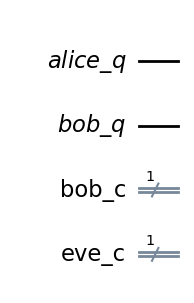

In [6]:
create_registers(DOES_EVE_EXIST).draw(output='mpl')

In [21]:
def setup_alice(circ):
    alice_q = circ.qubits[0]

    if random.getrandbits(1):
        circ.x(alice_q)

    if random.getrandbits(1):
        circ.h(alice_q)

    return circ

def setup_bob(circ):
    bob_q = circ.qubits[1]
    bob_c = circ.clbits[0]

    if random.getrandbits(1):
        circ.h(bob_q)

    circ.measure(bob_q, bob_c)

    return circ

def setup_eve(circ):
    bob_q = circ.qubits[1]
    eve_c = circ.clbits[1]

    circ.barrier()
    circ.measure(bob_q, eve_c)
    circ.barrier()

    return circ

In [22]:
def make_new_circuit(eve_exists):
    circ = create_registers(eve_exists)
    alice_q = circ.qubits[1]
    bob_q = circ.qubits[0]
    bob_c = circ.clbits[0]

    circ = setup_alice(circ)

    circ.swap(alice_q, bob_q)

    if eve_exists:
        circ = setup_eve(circ)

    circ = setup_bob(circ)
    
    return circ

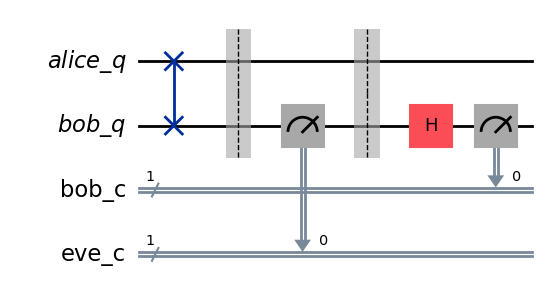

In [11]:
make_new_circuit(DOES_EVE_EXIST).draw(output='mpl')

In [23]:
def create_circuits(how_many, does_eve_exist):
    circuits = []
    for i in range(how_many):
        circuits.append(make_new_circuit(does_eve_exist))
    return circuits

In [24]:
def run_the_job(circuits):
    device = Aer.get_backend('qasm_simulator')
    new_circuits = transpile(circuits, device)
    job = device.run(new_circuits,shots=1, memory=True)
    return job.result()

pp.145: "To display the zeros and ones that Alice randomly generates, we can check each circuit’s count_ops
dictionary for the presence or absence of an X gate:"

In [57]:
def print_alice_bits(circuits):
    print("Alice's bits: ", end='')
    for circ in circuits:
        bit = 1 if 'x' in circ.count_ops() else 0
        print(bit, end='')
    print('')

def bob_bit_value(circ, memory):
    return memory[0][0]

def alice_bit_value(circ):
    return 1 if 'x' in circ.count_ops() else 0

def print_bob_bits(circuits, results):
    print("bob bits  :   ", end='')
    for circ in circuits:
        memory = results.get_memory(circ)
        print(bob_bit_value(circ, memory), end='')
    print('')

def had_agreement(circ):
    gate_counts = circ.count_ops()
    return not ('h' in gate_counts and gate_counts['h'] == 1)

def print_had_agreements(circuits):
    number_of_agreements = 0
    print('hads agree? ', end='')
    for circ in circuits:
        if had_agreement(circ):
            print(CHECK_MARK, end='')
            number_of_agreements += 1
        else:
            print(' ', end='')
    print('')
    return number_of_agreements



In [59]:
def bit_value_agreement(circ, results):
    memory = results.get_memory(circ)
    return alice_bit_value(circ) == int(bob_bit_value(circ, memory))

def print_bit_agreements(circuits, results, number_of_agreements):
    number_tested = 0
    is_eve_detected = False
    i = 0

    print('bits agree? ', end='')
    while number_tested < number_of_agreements // 2:
        if had_agreement(circuits[i]):
            if bit_value_agreement (circuits[i], results):
                print(CHECK_MARK, end='')
                number_tested += 1
            else:
                is_eve_detected = True
                print('X')
                break
        else:
            print(' ', end='')
        i += 1

    print('')

    return i, is_eve_detected

In [61]:
def print_key(circuits, number_of_circuits, how_many_for_testing):
    print('key       : ', end='')
    for i in range(how_many_for_testing + 1):
        print(' ', end='')
    for i in range(i, number_of_circuits): 
        if had_agreement(circuits[i]):
            print(alice_bit_value(circuits[i]), end='')
        else:
            print(' ', end='')

In [62]:
circuits = create_circuits(NUMBER_OF_CIRCUITS, DOES_EVE_EXIST)

result = run_the_job(circuits)

print_alice_bits(circuits)

print_bob_bits(circuits, result)

number_of_agreements = print_had_agreements(circuits)

how_many_for_testing, is_eve_detected = print_bit_agreements(circuits, result, number_of_agreements)

print(how_many_for_testing, is_eve_detected)

if is_eve_detected:
    print('INTRUDER ALERT!')
else:
    print_key(circuits, NUMBER_OF_CIRCUITS, how_many_for_testing)

Alice's bits: 0011010000100001100001101011101001110111
bob bits  :   1111110001100001010101101111101000110111
hads agree?      ✓✓    ✓ ✓✓   ✓ ✓ ✓✓✓ ✓✓ ✓✓✓✓ ✓   ✓✓
bits agree?      ✓✓    ✓ ✓✓   ✓ ✓ ✓✓
24 False
key       :                          1 11 0100 1   11